In [ ]:
# !apt-get install git-lfs
# !git lfs install  
# !git clone https://github.com/calico/spatial_lda.git
# !pip install lifelines
# !pip install palettable


# package location: /wynton/home/engelhardt/chwu/miniconda3/envs/NSF38/lib/python3.8/site-packages/spatial_lda

In [44]:
import os
import sys

os.chdir("/wynton/home/engelhardt/chwu/Projects/HubID/SpatialLDA")
PATH_TO_MODELS = f'./models/'
#PATH_TO_DF_PKL = f'./data//spleen_df.pkl'
PATH_TO_FEATURES_PKL = f'./data/G4423_transcript_features_sub_region2_mst_voronoi_d025.pkl'

# paths = [
#   PATH_TO_MODELS,
#   PATH_TO_SPLEEN_DF_PKL
# ]

# paths_exist = {path: os.path.exists(path) for path in paths}
# display(paths_exist)
# assert all(paths_exist.values())


In [43]:
%load_ext autoreload
%autoreload 2

import functools
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import tqdm
# Spatial LDA imports
from spatial_lda.featurization import neighborhood_to_cluster#, neighborhood_to_marker
from spatial_lda.featurization import make_nearest_neighbor_graph_distance
from spatial_lda.featurization import make_nearest_neighbor_graph
from spatial_lda.featurization import make_merged_difference_matrices
from spatial_lda.featurization import make_merged_difference_matrices_ori
from spatial_lda.featurization import featurize_samples
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
from spatial_lda.visualization import plot_topic_multicolor
import spatial_lda.model

N_PARALLEL_PROCESSES = 8#@param
TRAIN_SIZE_FRACTION = 0.99 #@param
N_TOPICS_LIST = [3, 5, 8, 10] #@param

logger = logging.getLogger()
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

# import inspect
# lines = inspect.getsource(neighborhood_to_cluster)
# print(lines)


In [3]:
# visualization parameters
blue = sns.color_palette()[0]
green = sns.color_palette()[1]
red = sns.color_palette()[2]
sns.set_context("paper",font_scale=1)
sns.set_style('white')
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

In [4]:
# mtx=scipy.sparse.load_npz("../neighbor_smooth/Data/G4423_15_neighbor_sums.npz")
# with open("../neighbor_smooth//Data/G4423_15_neighbor_sums_colnames.csv", "r+") as file1:
#     # Reading form a file
#     colnames=file1.read()
    
# colnames=colnames.strip("\n").split(",")


mtx=pd.read_csv("/gladstone/engelhardt/pelka-collaboration/Broad_MERFISH_Datasets/G4423_20220427/detected_transcripts.csv")

In [8]:
mtx['cluster']=mtx['gene']

In [10]:
mtx.head()

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cluster
0,5159,2,322.10700,695.01000,0.0,473.75510,284.62370,0,COL3A1,304636.0,COL3A1
1,5181,2,292.88403,711.09576,0.0,203.17223,433.56590,0,COL3A1,304636.0,COL3A1
2,5210,2,288.14970,728.09550,0.0,159.33578,590.97125,0,COL3A1,304636.0,COL3A1
3,5217,2,309.84427,733.52390,0.0,360.21143,641.23425,0,COL3A1,304636.0,COL3A1
4,5238,2,359.82944,744.04250,0.0,823.03710,738.62810,0,COL3A1,304636.0,COL3A1


In [ ]:
# mtx=mtx.iloc[:,1:]
# mtx

In [ ]:
# markers= mtx.columns
# markers=markers.tolist()
# len(markers)

In [ ]:
# mtx2=scipy.sparse.csr_matrix(np.array(mtx))
# scipy.sparse.save_npz('./Data/G4423_15_neighbor_sums.npz', mtx2)

In [ ]:
# mtx=pd.DataFrame(mtx.todense())
# mtx.columns=colnames
# mtx=mtx.iloc[:,1:]
# mtx

In [11]:
# import spatial info
#meta=pd.read_csv('/wynton/group/gladstone/users/cywu/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
#meta=pd.read_csv('/gladstone/engelhardt/pelka-collaboration/Broad_MERFISH_Datasets/G4423_20220427/cellpose_cell_metadata.csv')
coordinates0=np.array(mtx[['global_x', 'global_y']])
coordinates=coordinates0
coordinates



array([[  322.107  ,   695.01   ],
       [  292.88403,   711.09576],
       [  288.1497 ,   728.0955 ],
       ...,
       [14148.885  , 10118.43   ],
       [14215.998  , 10110.184  ],
       [14147.934  , 10245.508  ]])

In [12]:
# flip y
coordinates[:,1]=max(coordinates0[:,1])-coordinates0[:,1]

In [13]:
coordinates

array([[  322.107  , 10945.713  ],
       [  292.88403, 10929.62724],
       [  288.1497 , 10912.6275 ],
       ...,
       [14148.885  ,  1522.293  ],
       [14215.998  ,  1530.539  ],
       [14147.934  ,  1395.215  ]])

In [ ]:
#print(list(mtx.columns[0:550]))

# Generate inputs for running Spatial LDA

In [14]:
mtx['isb']=True
mtx['sample']='G4423'
mtx['sample.X']=coordinates[:,0]
mtx['sample.Y']=coordinates[:,1]



In [42]:
# subsample and generate dic
import random
random.seed(100)
#idx=random.sample(range((mtx.shape[0])), 5000)#int(mtx.shape[0]*0.1))
idx=np.array([*range(mtx.shape[0])])
idx=idx[((coordinates[:,0]>4500) & (coordinates[:,0]<7000)) & ((coordinates[:,1]<max(coordinates[:,1])) & (coordinates[:,1]>(max(coordinates[:,1])-2500)))]

df_dict = {'G4423': mtx.loc[idx]}
#df_dict['G4423_2']=mtx.loc[idx[1000:2000]]
df_dict

{'G4423':           Unnamed: 0  barcode_id   global_x   global_y  global_z           x  \
 4198595          170           0  4500.6885 -205.82294       0.0  1596.43710   
 4198596          174           0  4515.1660 -205.17198       0.0  1730.48660   
 4198600          206           0  4520.9673 -201.73943       0.0  1784.20180   
 4198604          248           0  4529.0190 -197.16127       0.0  1858.75440   
 4198610          298           0  4527.5874 -192.48874       0.0  1845.50090   
 ...              ...         ...        ...        ...       ...         ...   
 15912183     2165410         548  6960.4640  480.08466       1.0   551.17584   
 15912185     2166687         548  6979.9097  634.01890       1.0   731.22736   
 15912187     2168845         548  6990.1080  495.76920       3.0   825.65780   
 15912193     2172482         548  6981.4585  528.76650       5.0   745.56995   
 15912194     2175811         549  6988.0930  588.55600       2.0   807.00000   
 
                 

In [32]:
# # visualize LCN2
# idx=np.array([*range(mtx.shape[0])])
# idx_tmp=idx[((coordinates[:,0]>4500) & (coordinates[:,0]<7000)) & ((coordinates[:,1]<max(coordinates[:,1])) & (coordinates[:,1]>(max(coordinates[:,1])-2500))) & (np.array(mtx.cluster)=='LCN2')]
# #df_dict = {'G4423': mtx.loc[idx_tmp]}
# df_dict = {'G4423': mtx.loc[idx_tmp]}
# df_dict['G4423']

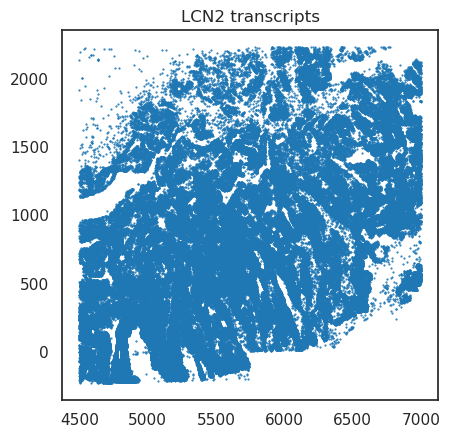

In [41]:
# import numpy as np
# import matplotlib.pyplot as plt
# plt.scatter(df_dict['G4423'].global_x, df_dict['G4423'].global_y, s=0.3)
# plt.title("LCN2 transcripts")
# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
# plt.draw()

In [ ]:
# Featurize the data
#%%time
for df in df_dict.values():
    df['x'] = df['sample.X']
    df['y'] = df['sample.Y']
#wt_samples = [ x for x in codex_df_dict.keys() if x.startswith("BALBc")]
#spleen_dfs = dict(zip(wt_samples, [ codex_df_dict[x] for x in wt_samples]))

# neighborhood_feature_fn = functools.partial(neighborhood_to_marker, 
#                                              markers=markers)  
# original cells_features function 
cells_features = featurize_samples(df_dict, neighborhood_to_cluster, 100,'isb',
                             'sample.X', 'sample.Y', include_anchors=True, #all cells are ahcnors
                             n_processes=N_PARALLEL_PROCESSES)

# # generate cells_features without running featurize_samples
# cells_features=mtx.iloc[idx,range(0,(mtx.shape[1]-4))]
# cidx=cells_features.index.tolist()
# rn=[]
# for ii in range(len(cidx)):
#     rn.append(tuple(["G4423",cidx[ii]]))
# cells_features.index=rn

#featurize_spleens(spleen_dfs, neighborhood_to_cluster, radius=100,n_processes=N_PARALLEL_PROCESSES)
with open(PATH_TO_FEATURES_PKL, 'wb') as f:
   pickle.dump(cells_features, f)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

In [ ]:
cells_features

In [ ]:
## original script for refernece
# from scipy.spatial import Voronoi
# sample_features = cells_features
# sample_dfs = df_dict
# x_col='sample.X'
# y_col='sample.Y'
# z_col= None
# reduce_to_mst=False

# #def make_nearest_neighbor_graph(sample_features, sample_dfs, sample_idx, x_col, y_col, z_col=None):
# sample_idxs = sample_features.index.map(lambda x: x[0])
# sample_idx = sample_idxs[0] ###
# sample_rows = sample_features[sample_idxs == sample_idx]
# cell_idx = sample_rows.index.map(lambda x: x[1])
# if z_col is None:
#     coords = [x_col, y_col]
# else:
#     coords = [x_col, y_col, z_col]
# cell_coords = sample_dfs[sample_idx].loc[cell_idx][coords].values
# vor = Voronoi(cell_coords)
# num_edges = vor.ridge_points.shape[0]
# num_nodes = len(cell_coords)
# src_nodes = vor.ridge_points[:, 0]
# dst_nodes = vor.ridge_points[:, 1]
# coord_difference = cell_coords[src_nodes] - cell_coords[dst_nodes]
# edge_lengths = np.sqrt(np.sum(coord_difference**2.0, axis=1))
# #    assert len(edge_lengths) == num_edges
# #    return num_nodes, src_nodes, dst_nodes, edge_lengths

In [ ]:
# print(num_edges)
# print(num_nodes)
# print(len(src_nodes))
# print(src_nodes[0:20])
# print(dst_nodes[0:10])
# print(coord_difference)

In [ ]:
# # revised script
# from scipy.spatial import Voronoi
# from sklearn.neighbors import NearestNeighbors

# sample_features = cells_features
# sample_dfs = df_dict
# x_col='sample.X'
# y_col='sample.Y'
# z_col= None
# reduce_to_mst=False
# n_neighbors=5

# #def make_nearest_neighbor_graph2(sample_features, sample_dfs, sample_idx, x_col, y_col, z_col=None, n_neighbors=1):
# sample_idxs = sample_features.index.map(lambda x: x[0])
# sample_idx = sample_idxs[0] ###
# sample_rows = sample_features[sample_idxs == sample_idx]
# cell_idx = sample_rows.index.map(lambda x: x[1])
# if z_col is None:
#     coords = [x_col, y_col]
# else:
#     coords = [x_col, y_col, z_col]
# cell_coords = sample_dfs[sample_idx].loc[cell_idx][coords].values
# #vor = Voronoi(cell_coords)
# num_edges = len(cell_coords) * (n_neighbors+1)#vor.ridge_points.shape[0]
# num_nodes = len(cell_coords)

# ## n nearest neighbors
# fit = NearestNeighbors(n_neighbors=(n_neighbors+1)).fit(cell_coords)
# m = fit.kneighbors(cell_coords, return_distance=True)


# src_nodes = np.repeat(range(num_nodes), n_neighbors)#vor.ridge_points[:, 0]
# dst_nodes = m[1][:,1:].flatten()#vor.ridge_points[:, 1]
# #coord_difference = #cell_coords[src_nodes] - cell_coords[dst_nodes]
# edge_lengths = m[0][:,1:].flatten()#np.sqrt(np.sum(coord_difference**2.0, axis=1))
# #    assert len(edge_lengths) == num_edges
# #    return num_nodes, src_nodes, dst_nodes, edge_lengths

In [ ]:
# edge_lengths.flatten()[0:20]

In [ ]:
# coord_difference = cell_coords[src_nodes] - cell_coords[dst_nodes]
# edge_lengths2 = np.sqrt(np.sum(coord_difference**2.0, axis=1))
# edge_lengths2[0:20]

In [ ]:
# # test nearest neighbors
# from sklearn.neighbors import NearestNeighbors
# n_neighbors=5
# fit = NearestNeighbors(n_neighbors=n_neighbors).fit(cell_coords)
# m = fit.kneighbors(cell_coords, return_distance=True)

In [ ]:
# coord_difference = cell_coords[src_nodes] - cell_coords[dst_nodes]
# edge_lengths = np.sqrt(np.sum(coord_difference**2.0, axis=1))
# print(edge_lengths)
# print(m[0])
# ## the two are the same

In [ ]:
# # sort the neighbors
# args = m[0].argsort(axis=1)
# add = np.arange(m[1].shape[0])*m[1].shape[1]
# sorted_indices = m[1].flatten()[args+add[:, None]]
# # neighbors = metadata.index.values[sorted_indices].astype(np.int32)
# # transcriptsbyneighborhood = pd.DataFrame([cellbygene.loc[neighbors[index], :].sum() for index, cell_id 
# # in enumerate(cellbygene.index.values.tolist())])

In [ ]:
# #def make_difference_matrix(num_nodes, src_nodes, dst_nodes):
# # the matrix--each row is a edge-- staring point=1; dist point=-1
# num_edges = len(src_nodes)
# rows = np.hstack([np.arange(num_edges), np.arange(num_edges)])
# cols = np.hstack([src_nodes, dst_nodes])
# values = np.hstack([np.ones(num_edges), -1 * np.ones(num_edges)])
# #difference_matrix = coo_matrix(
# #    (values, (rows, cols)), shape=(num_edges, num_nodes)).tocsr()
# #return difference_matrix



In [ ]:
# def make_merged_difference_matrices(sample_features, sample_dfs,
#                                     x_col, y_col, z_col=None,
#                                     reduce_to_mst=True):
#     difference_matrices = dict()
#     sample_idxs = sample_features.index.map(lambda x: x[0])
#     for sample_idx in set(sample_idxs):
#         graph = make_nearest_neighbor_graph(
#             sample_features, sample_dfs, sample_idx, x_col, y_col, z_col=z_col)
#         num_nodes, src_nodes, dst_nodes, edge_lengths = graph
# #         difference_matrix = make_difference_matrix(
# #             num_nodes, src_nodes, dst_nodes)
# #         if reduce_to_mst:
# #             mst_mask = make_minimum_spaning_tree_mask(
# #                 num_nodes, src_nodes, dst_nodes, edge_lengths)
# #             difference_matrix = difference_matrix[mst_mask, :]
# #         difference_matrices[sample_idx] = difference_matrix
#     return difference_matrices

In [ ]:
# difference_matrices = make_merged_difference_matrices(cells_features, df_dict,
#                                                              'sample.X', 'sample.Y', reduce_to_mst=False)

In [ ]:
import inspect
print(os.path.abspath(inspect.getfile(featurize_samples)))

In [ ]:
cells_features.sum(1)

In [ ]:
#difference_matrices = make_merged_difference_matrices(cells_features, df_dict,
#                                                             'sample.X', 'sample.Y', n_neighbors=5, reduce_to_mst=True)
all_sample_idxs = cells_features.index.map(lambda x: x[0])
_sets = train_test_split(cells_features, 
                         test_size=1. - TRAIN_SIZE_FRACTION,
                         stratify=all_sample_idxs)
train_cells_features, test_cells__features = _sets
train_difference_matrices = make_merged_difference_matrices_ori(
    cells_features, df_dict,
    'sample.X', 'sample.Y', n_neighbors=5, reduce_to_mst=True)
train_idxs = train_cells_features.index.map(lambda x: x[0])

In [ ]:
from spatial_lda.visualization import plot_adjacency_graph

def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(difference_matrices)

plot_samples_in_a_row(cells_features, _plot_fn, df_dict)

In [ ]:
from spatial_lda.visualization import plot_samples_in_a_row
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from spatial_lda.visualization import plot_samples_in_a_row
with PdfPages('./plots/G4423_prior_only_subregion2_adjacency_nomst_5nn.pdf') as pdf_pages:
    # df1 = dftest.select_dtypes([np.int, np.float, np.object])
    # for i, col in enumerate(N_TOPICS_LIST):
    #     figu = plt.figure(i)
    #     plot = sns.countplot(x=col, data=df1)
    #     pdf_pages.savefig(figu)
    plt.figure()
    plot_samples_in_a_row(cells_features, _plot_fn, df_dict)
    pdf_pages.savefig()
    plt.close()

# Spatial LDA results

In [ ]:
N_TOPICS_LIST = [3, 5, 8, 10, 20] #@param
#N_TOPICS_LIST = [20, 30, 50] #@param
N_TOPICS_LIST

In [ ]:
from spatial_lda.model import order_topics_consistently
spatial_lda_models = {}  
difference_penalty = 0.25#10000000000#0.25   
for n_topics in N_TOPICS_LIST:
  #path_to_train_model = '_'.join((f'{PATH_TO_MODELS}/training_prior_only_subregion2',
  path_to_train_model = '_'.join((f'{PATH_TO_MODELS}/training_transcripts_subregion2_mst_voronoi_d025',
                                  f'penalty={difference_penalty}',
                                  f'topics={n_topics}',
                                  f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'
  if not os.path.exists(path_to_train_model):
    print(f'Running n_topics={n_topics}, d={difference_penalty}\n')
    spatial_lda_model = spatial_lda.model.train(sample_features=cells_features, 
                                                difference_matrices=train_difference_matrices,
                                                difference_penalty=difference_penalty,
                                                n_topics=n_topics,
                                                n_parallel_processes=N_PARALLEL_PROCESSES,                                                                         
                                                verbosity=1,
                                                admm_rho=0.1,
                                                primal_dual_mu=1e+5)
    spatial_lda_models[n_topics] = spatial_lda_model
    with open(path_to_train_model, 'wb') as f:
      pickle.dump(spatial_lda_model, f)    
  else:
    with open(path_to_train_model, 'rb') as f:
      spatial_lda_models[n_topics] = pickle.load(f)
      
order_topics_consistently(spatial_lda_models.values())     

In [ ]:
lda_3 = spatial_lda_models[3]
topic_weights_3 = lda_3.topic_weights
lda_5 = spatial_lda_models[5]
topic_weights_5 = lda_5.topic_weights
lda_8 = spatial_lda_models[8]
topic_weights_8 = lda_8.topic_weights
lda_10 = spatial_lda_models[10]
topic_weights_10 = lda_10.topic_weights
samples = ['G4423']

lda_20 = spatial_lda_models[20]
topic_weights_20 = lda_20.topic_weights
# lda_30 = spatial_lda_models[30]
# topic_weights_30 = lda_30.topic_weights
# lda_50 = spatial_lda_models[50]
# topic_weights_50 = lda_50.topic_weights
samples = ['G4423']

In [ ]:
# # explore topics
# (lda_3.components_)#.sum(axis=1))
# #model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
# #  components_ : array, [n_components, n_features]
# #         Variational parameters for topic word distribution. Since the complete
# #         conditional for topic word distribution is a Dirichlet,
# #         ``components_[i, j]`` can be viewed as pseudocount that represents the
# #         number of times word `j` was assigned to topic `i`.
# #         It can also be viewed as distribution over the words for each topic
# #         after normalization:
# #         ``model.components_ / model.components_.sum(axis=1)[:, np.newaxis]``.
# topic_word= (lda_3.components_)/(lda_3.components_).sum(axis=1)[:, np.newaxis]

In [ ]:
# save topic info to csv using for loop
#all_vars=dir()
sel_vars=[]
for ii in all_vars:
    if "lda_" in ii:
        sel_vars.append(ii)
print(sel_vars)

In [ ]:
for ii in sel_vars[0:(len(sel_vars)-1)]:
    lda=globals()[ii]
    topic_word = (lda.components_)/(lda.components_).sum(axis=1)[:, np.newaxis]
    topic_word_df=pd.DataFrame(topic_word)
    topic_word_df.columns=markers
    topic_word_df.to_csv("./tables/G4420_transcripts_subregion2_mst_voronoi_d025_topic_word_"+ii+"_.csv")
    print(ii)

In [ ]:
globals()['lda_10']

In [ ]:
# topic_word_df=pd.DataFrame(topic_word)
# topic_word_df.columns=markers
# topic_word_df
# df_topic_info.to_csv("./tables/G4420_subregion_topic_info_hdp_seed0.csv")

In [ ]:
lda_3.__dict__

In [ ]:
from spatial_lda.visualization import plot_bcell_topic_multicolor
from spatial_lda.visualization import plot_topic_multicolor
from spatial_lda.visualization import plot_samples_in_a_row
from matplotlib.backends.backend_pdf import PdfPages

#with PdfPages('./plots/G4423_prior_only_subregion2_topic_weights_extended_001.pdf') as pdf_pages:
with PdfPages('./plots/G4423_transcripts_subregion2_mst_voronoi_d025_topic_weights_extended_001.pdf') as pdf_pages:
    # df1 = dftest.select_dtypes([np.int, np.float, np.object])
    # for i, col in enumerate(N_TOPICS_LIST):
    #     figu = plt.figure(i)
    #     plot = sns.countplot(x=col, data=df1)
    #     pdf_pages.savefig(figu)
    plt.figure()
    plot_samples_in_a_row(topic_weights_3, plot_topic_multicolor, df_dict, tumor_set=samples)
    pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
    plt.close()
    
    plt.figure()
    plot_samples_in_a_row(topic_weights_5, plot_topic_multicolor, df_dict, tumor_set=samples)
    pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
    plt.close()
    
    plt.figure()
    plot_samples_in_a_row(topic_weights_8, plot_topic_multicolor, df_dict, tumor_set=samples)
    pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
    plt.close()
    
    plt.figure()
    plot_samples_in_a_row(topic_weights_10, plot_topic_multicolor, df_dict, tumor_set=samples)
    pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
    plt.close()
    
    plt.figure()
    plot_topic_multicolor_fn = functools.partial(plot_topic_multicolor, seed=23)  
    plot_samples_in_a_row(topic_weights_20, plot_topic_multicolor_fn, df_dict, tumor_set=samples)
    pdf_pages.savefig(bbox_inches="tight", pad_inches=0.2)
    plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_30,plot_topic_multicolor6, df_dict, tumor_set=samples)
#     pdf_pages.savefig()
#     plt.close()
    
#     plt.figure()
#     plot_samples_in_a_row(topic_weights_50,plot_topic_multicolor6, df_dict, tumor_set=samples)
#     pdf_pages.savefig()
#     plt.close()
    
    
    
    

In [ ]:
import palettable.cartocolors.qualitative as qual_palettes
color_palette = qual_palettes.Bold_10.mpl_colors
colors = np.array(color_palette[:10])
colors

In [ ]:
from spatial_lda.visualization import plot_topic_multicolor7

In [ ]:
topic_weights_20.shape

In [ ]:
# # prior only
# from spatial_lda.visualization import plot_samples_in_a_row
# from spatial_lda.visualization import plot_bcell_topic_multicolor
# from spatial_lda.visualization import plot_topic_multicolor4
# plot_samples_in_a_row(topic_weights_3, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_5, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_8, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_10, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_20, plot_topic_multicolor4, df_dict, tumor_set=samples)

In [ ]:
# prior only
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
from spatial_lda.visualization import plot_topic_multicolor
plot_samples_in_a_row(topic_weights_3, plot_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_5, plot_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_8, plot_topic_multicolor, df_dict, tumor_set=samples)
plot_samples_in_a_row(topic_weights_10, plot_topic_multicolor, df_dict, tumor_set=samples)
plot_topic_multicolor10_fn = functools.partial(plot_topic_multicolor, seed=23 ) 
plot_samples_in_a_row(topic_weights_20, plot_topic_multicolor10_fn, df_dict, tumor_set=samples)

In [ ]:
# # no smoothing no mst
# from spatial_lda.visualization import plot_samples_in_a_row
# from spatial_lda.visualization import plot_bcell_topic_multicolor3
# from spatial_lda.visualization import plot_topic_multicolor5
# plot_samples_in_a_row(topic_weights_3, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_5, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_8, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_10, plot_bcell_topic_multicolor3, df_dict, tumor_set=samples)
# plot_samples_in_a_row(topic_weights_20, plot_topic_multicolor5, df_dict, tumor_set=samples)